Understanding Debt Burden in Homeowners, a Supervised Learning Approach

Problem Description:
Rapidly increasing Housing prices and mortgage debt is a major problem in the USA, especially as interest rates have increased in the last few years, while homeownership is considered a critical step for most people in building wealth. One indicator of the finanical stress is Household debt to income (DTI) ratio, the percentage of a household's income required to service their debts (or practically, the amount of their debt payments in a month divided by monthly income)(Murphy). A certain group of borrowers having a DTI ratio greater than 43% are debt burdened and very vulnerable to financial shocks. They also have difficulty contributing to financial goals outside of and including paying off debt. The problem under investigation is what variables correlate with being debt burdened for single borrowers mortgaging a primary residence. A logistic regression will be used to test whether variables like borrower race, area median household income, area minority percentage, borrower credit score, and mortgage interest rate, among others, can contribute to a model that will incdicate whether a borrower is more or less likely to be debt burdened. A model such as this can then be used to target interventions to households to either prevent them from becoming debt burdened or increase assistance with overcoming debt based on the contributing factors.
 
 Source: Murphy, C. B. (n.d.). Debt-to-income (DTI) ratio: What’s good and how to calculate it. Investopedia. https://www.investopedia.com/terms/d/dti.asp 


Data:
The data used for this problem is provided by the USA Federal Housing Finance Agency. It is from a single source in a public use database of mortgage aquistions by Fannie Mae and Freddie Mac, the federally backed home mortgage companies created by the federal government to help mangage housing and mortgage markets. The FHLBank Public Use Database has data from the year 2022 and includes 33018 rows of mortgages and 56 intial columns of variables(2023). There are 24 numeric and 32 categorical variables contained in the dataset. There is also a convenient PDF file called "2022 Definitions" included with the dataset that lists the name, meaning, and allowed values of each variable. Many are not pertinant and will be removed from the initial dataset or are highly correlated so will not be used together in the same model. For example there is a numeric variable called LocMedY, the local area median income based on census data, and another measure of local income called CurAreY, local area median income for a family of four based on HUD. Both measure a similar underlying population for the same variable. To create the debt burden variable of interest, another variable, TotalDebtExpenseRatioPercent, was used to create a binary categorical variable where 1 represents values greater than 43 and 0 represents those below 43 (not burdened). Other categorial variables for borrower 1 race and gender were also converted to binary categorical variables. The function clean_data below was used to adapt the data to the problem being investigated and the final dataset contained 7688 rows and 18 columns with 10 numeric and 8 categorical variables 

Source: Public Use Database - Fannie Mae and Freddie Mac. Public Use Databases | Federal Housing Finance Agency. (2023b, September 25). https://www.fhfa.gov/DataTools/Downloads/Pages/Public-Use-Databases.aspx 

In [1]:
from math import exp
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
#%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [2]:
# Here is the function for removing and adding variables plus reducing the dataset so it only includes loans 
#for a single borrower's primary residence   
def clean_data(name):
    mortdat = pd.read_csv(name)
    print("Initial Data size: Rows, Columns")
    print(mortdat.shape[0])
    print(mortdat.shape[1])
    #filter out unnecessary columns
    mortdat = mortdat.drop(columns=['Year', 'LoanCharacteristicsID','Bank', 'FIPSCountyCode','CoreBasedStatisticalAreaCode'
                                    ,'CensusTractIdentifier','LoanAcquisitionActualUPBAmt','MortgageLoanSellerInstType',
                                    'LoanAmortizationMaxTermMonths', 'MortgageType','NoteDate', 'LoanAcquistionDate',
                                    'MortgageLoanSellerInstType','ScheduledTotalPaymentCount','Borrower2Race1Type',
                                    'Borrower2GenderType','Borrower2AgeAtApplicationYears',
                                    'PropertyUnitCount','Borrower2CreditScoreValue','PMICoveragePercent',
                                    'IndexSourceType','MarginRatePercent','PrepaymentPenaltyExpirationDate',
                                    'Borrower2EthnicityType','Borrower2Race2Type','Borrower2Race3Type',
                                    'Borrower2Race4Type','Borrower2Race5Type','HOEPALoanStatusType','LienPriorityType',
                                    'Borrower1Race2Type', 'Borrower1Race3Type', 'Borrower1Race4Type', 'Borrower1Race5Type',
                                    ])

    # removing rows with values from specific columns to remove blank values, non-primary-residences, non-single values
    mask1 = mortdat['LoanPurposeType'] != 1
    mortdat = mortdat[~mask1]
    mask2 = mortdat['ProductCategoryName'] != 1
    mortdat = mortdat[~mask2]
    mask3 = mortdat['BorrowerCount'] != 1
    mortdat = mortdat[~mask3]
    mask4 = mortdat['Borrower1Race1Type'] == 6
    mortdat = mortdat[~mask4]
    mask5 = mortdat['Borrower1Race1Type'] == 7
    mortdat = mortdat[~mask5]
    mask6 = mortdat['PropertyUsageType'] != 1
    mortdat = mortdat[~mask6]
    mask7 = mortdat['Borrower1AgeAtApplicationYears'] == 999
    mortdat = mortdat[~mask7]
    mask8 = mortdat['Borrower1GenderType'] == 3
    mortdat = mortdat[~mask8]
    mask9 = mortdat['Borrower1GenderType'] == 4
    mortdat = mortdat[~mask9]
    mask10 = mortdat['Borrower1GenderType'] == 6
    mortdat = mortdat[~mask10]
    mask9 = mortdat['Borrower1EthnicityType'] == 3
    mortdat = mortdat[~mask9]
    mask10 = mortdat['Borrower1EthnicityType'] == 4
    mortdat = mortdat[~mask10]
    #remove more columns
    mortdat = mortdat.drop(columns=['LoanPurposeType','ProductCategoryName','BorrowerCount','PropertyUsageType'
                                    ])
    mortdat = mortdat.drop(columns=['PropertyType','FIPSStateNumericCode'])
    
   
    
    #make gender column zero for male and one for female, so male is default
    mortdat['IsFemale'] = np.where(mortdat['Borrower1GenderType'] == 2, 1, 0)
    mortdat = mortdat.drop(columns=['Borrower1GenderType'])
    
    #Convert Ethnicity variable into several "IsMinority" variables for different racial identities, white will not get 
    #a new variable and will be the default
    mortdat['IsHispanic'] = np.where(mortdat['Borrower1EthnicityType'] == 1, 1, 0)
    mortdat['IsNativeAmerican'] = np.where(mortdat['Borrower1Race1Type'] == 1, 1, 0)
    mortdat['IsAsian'] = np.where(mortdat['Borrower1Race1Type'] == 2, 1, 0)
    mortdat['IsBlack'] = np.where(mortdat['Borrower1Race1Type'] == 3, 1, 0)
    mortdat['IsPacificIslander'] = np.where(mortdat['Borrower1Race1Type'] == 4, 1, 0)
    mortdat = mortdat.drop(columns=['Borrower1Race1Type','Borrower1EthnicityType'])
    
    #add column for TotalDebtExpenseRatioPercent being greater than 43%, where it gets dangerous
    mortdat['DebtBurdened'] = np.where(mortdat['TotalDebtExpenseRatioPercent'] > 43, 1, 0)
    mortdat = mortdat.drop(columns=['HousingExpenseRatioPercent','TotalDebtExpenseRatioPercent'])
    
    
    print(list(mortdat.columns))
    
    print("Final Data size: Rows, Columns")
    print(mortdat.shape[0])
    print(mortdat.shape[1])
    return mortdat


In [3]:
#Here is where you upload the csv file from https://www.fhfa.gov/DataTools/Downloads/Pages/Public-Use-Databases.aspx. 
# if you named it something other than MortData1 please update the file name below. 
new_data = clean_data("MortData1.csv")


Initial Data size: Rows, Columns
33018
56
['CensusTractMinorityRatioPercent', 'CensusTractMedFamIncomeAmount', 'LocalAreaMedianIncomeAmount', 'TotalMonthlyIncomeAmount', 'HUDMedianIncomeAmount', 'LTVRatioPercent', 'BorrowerFirstTimeHomebuyer', 'Borrower1AgeAtApplicationYears', 'NoteRatePercent', 'NoteAmount', 'Borrower1CreditScoreValue', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsHispanic', 'IsNativeAmerican', 'IsAsian', 'IsBlack', 'IsPacificIslander', 'DebtBurdened']
Final Data size: Rows, Columns
7710
19


In [4]:
#This is the function for exploratory data analysis
def explore_data(name):
    #print(name.head())
    for i in list(name.columns):
        print(i)
        print(min(name[i]))
        print(max(name[i]))
        print(name[i].mean())
        print(name[i].value_counts())
        

In [5]:
explore_data(new_data)

CensusTractMinorityRatioPercent
0.0
99.677
22.43771841763943
CensusTractMinorityRatioPercent
7.000     41
6.000     39
5.000     35
4.000     35
11.000    27
          ..
47.481     1
36.703     1
14.052     1
45.298     1
34.029     1
Name: count, Length: 5053, dtype: int64
CensusTractMedFamIncomeAmount
0
250001
85141.04980544747
CensusTractMedFamIncomeAmount
0        22
73750    17
69583    15
62500    15
77500    14
         ..
40838     1
67175     1
71090     1
93154     1
42784     1
Name: count, Length: 5146, dtype: int64
LocalAreaMedianIncomeAmount
0
141569
79034.16848249028
LocalAreaMedianIncomeAmount
92668     272
84758     215
68958     215
103977    165
86296     155
         ... 
57976       1
69231       1
63469       1
63851       1
78974       1
Name: count, Length: 734, dtype: int64
TotalMonthlyIncomeAmount
869
108951
7430.494033722438
TotalMonthlyIncomeAmount
6250     36
10000    35
5000     34
4333     33
3640     29
         ..
5558      1
13081     1
17673     1
24

The initial data exploration showed some irregularities with zero values that were probably used as missing values in CensusTractMedFamIncomeAmount and LocalAreaMedianIncomeAmount that I need to remove. There were also so few Pacific Islanders (only 13) that I decdied to drop that entire column to avoid unbalance. 

In [6]:
#removing missing values and problem column identified in initial data exploration
def final_clean(data):
    data = data.drop(columns=['IsPacificIslander'])
    mask1 = data['CensusTractMedFamIncomeAmount'] == 0
    data = data[~mask1]
    mask2 = data['LocalAreaMedianIncomeAmount'] == 0
    data = data[~mask2]
    print("List of Variables")
    print(list(data.columns))
    
    print("Final Data size: Rows, Columns")
    print(data.shape[0])
    print(data.shape[1])
    return data

In [7]:
final_data = final_clean(new_data)

List of Variables
['CensusTractMinorityRatioPercent', 'CensusTractMedFamIncomeAmount', 'LocalAreaMedianIncomeAmount', 'TotalMonthlyIncomeAmount', 'HUDMedianIncomeAmount', 'LTVRatioPercent', 'BorrowerFirstTimeHomebuyer', 'Borrower1AgeAtApplicationYears', 'NoteRatePercent', 'NoteAmount', 'Borrower1CreditScoreValue', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsHispanic', 'IsNativeAmerican', 'IsAsian', 'IsBlack', 'DebtBurdened']
Final Data size: Rows, Columns
7688
18


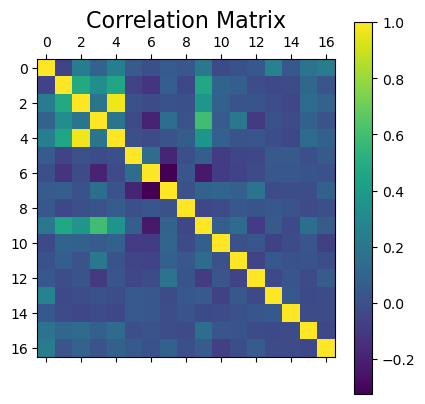

In [8]:
#create correlation matrix of data
def corr_matrix(dataframe):
    matrix = dataframe.corr()
    plt.matshow(matrix)
    cb = plt.colorbar()
    plt.title('Correlation Matrix', fontsize=16);
    plt.show()
#generate correlation matrix of potential input variables
corr_matrix(final_data.iloc[:,:17])

There is very low correlation between most of these variables, but there are a few where that is not the case. Some of those have a clear logical explanation, like the strong negative correlation between variables 6,BorrowerFirstTimeHomebuyer, and 7,  Borrower1AgeAtApplicationYears, because the younger adults are more likely to be a first time homebuyers. The relationship between variables 3, TotalMonthlyIncomeAmount, and 9, NoteAmount is also simple, because people with higher incomes are more likely to be approved for larger mortgages. Variable 9, seems to be positively and negatively correlated with several variables and extra care will be needed if it is incldued in any model to insure that it does not cause an issue. The near perfect correlations with variables 2,'LocalAreaMedianIncomeAmount', and 4,HUDMedianIncomeAmount, makes sense because those measure nearly the same population for the same measurement. 

In [9]:
#Generating models 
def model_data(name):
    print("Variables Included")
    varlist = list(name.columns)
    varlist = varlist[:len(varlist)-1]
    print(varlist)
    x_train, x_test, y_train, y_test = train_test_split(name[varlist],name['DebtBurdened'],random_state = 1)
    LogReg = LogisticRegression(solver='liblinear').fit(x_train, y_train)
    # your code here
    ypp = LogReg.predict_proba(x_test)
    fpr, tpr, th = roc_curve(y_test, ypp[:, 1])
    auc = roc_auc_score(y_test, ypp[:, 1])
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(fpr, tpr)
    ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1))
    ax1.set_title("ROC CURVE:Test Data")
    ax1.set_xlabel("FPR")
    ax1.set_ylabel("TPR")
    ax1.text(0.5, 0.2, 'AUC=' + "{:.3f}".format(auc))
    # code for ROC Curve for training data
    ypp = LogReg.predict_proba(x_train)
    fpr2, tpr2, th2 = roc_curve(y_train, ypp[:, 1])
    auc = roc_auc_score(y_train, ypp[:, 1])
    ax2.plot(fpr2, tpr2)
    ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1))
    ax2.set_title("ROC CURVE:Training Data")
    ax2.set_xlabel("FPR")
    ax2.text(0.5, 0.2, 'AUC=' + "{:.3f}".format(auc))
    
    return LogReg

Variables Included
['CensusTractMinorityRatioPercent', 'CensusTractMedFamIncomeAmount', 'LocalAreaMedianIncomeAmount', 'TotalMonthlyIncomeAmount', 'HUDMedianIncomeAmount', 'LTVRatioPercent', 'BorrowerFirstTimeHomebuyer', 'Borrower1AgeAtApplicationYears', 'NoteRatePercent', 'NoteAmount', 'Borrower1CreditScoreValue', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsHispanic', 'IsNativeAmerican', 'IsAsian', 'IsBlack']


LogisticRegression(solver='liblinear')

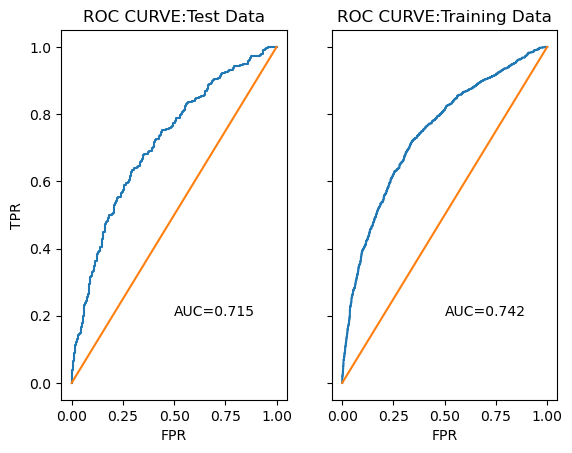

In [10]:
#Model with all Data
model_data(final_data)


CensusTractMinorityRatioPercent
Variables Included
['CensusTractMinorityRatioPercent']
CensusTractMedFamIncomeAmount
Variables Included
['CensusTractMedFamIncomeAmount']
LocalAreaMedianIncomeAmount
Variables Included
['LocalAreaMedianIncomeAmount']
TotalMonthlyIncomeAmount
Variables Included
['TotalMonthlyIncomeAmount']
HUDMedianIncomeAmount
Variables Included
['HUDMedianIncomeAmount']
LTVRatioPercent
Variables Included
['LTVRatioPercent']
BorrowerFirstTimeHomebuyer
Variables Included
['BorrowerFirstTimeHomebuyer']
Borrower1AgeAtApplicationYears
Variables Included
['Borrower1AgeAtApplicationYears']
NoteRatePercent
Variables Included
['NoteRatePercent']
NoteAmount
Variables Included
['NoteAmount']
Borrower1CreditScoreValue
Variables Included
['Borrower1CreditScoreValue']
EmploymentBorrowerSelfEmployed
Variables Included
['EmploymentBorrowerSelfEmployed']
IsFemale
Variables Included
['IsFemale']
IsHispanic
Variables Included
['IsHispanic']
IsNativeAmerican
Variables Included
['IsNativeAm

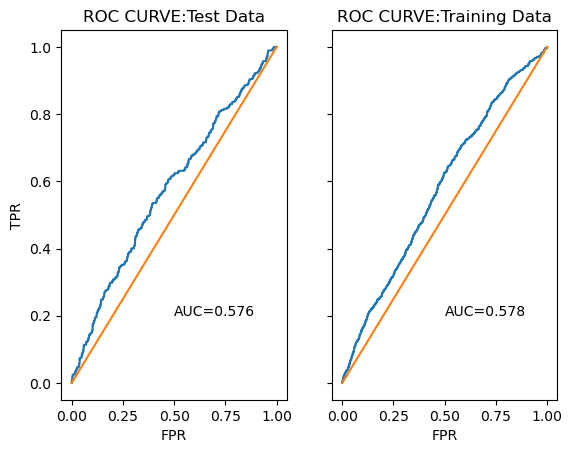

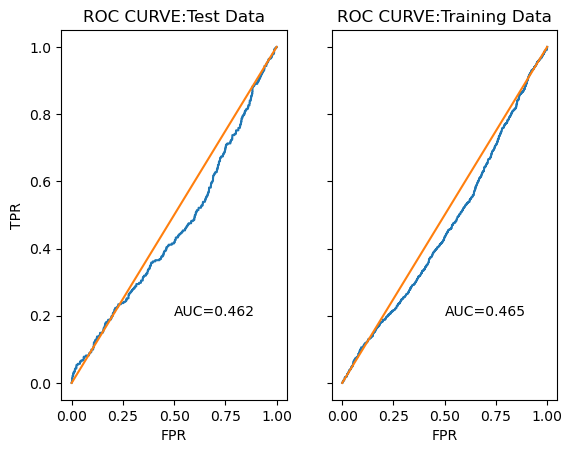

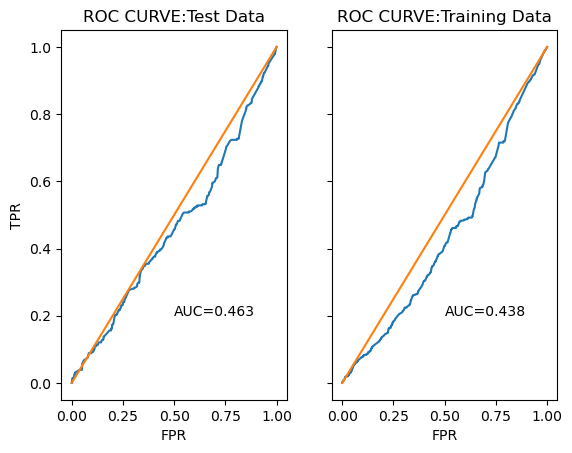

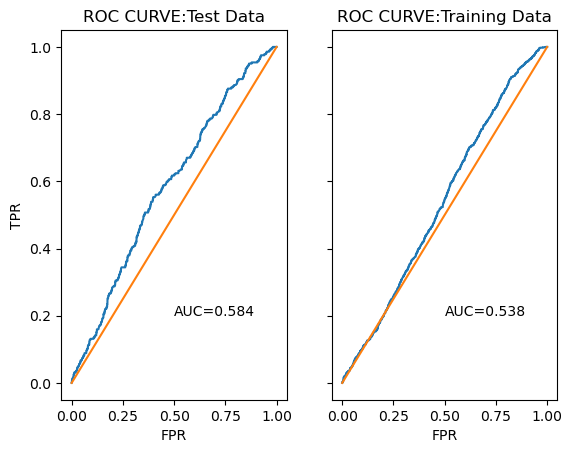

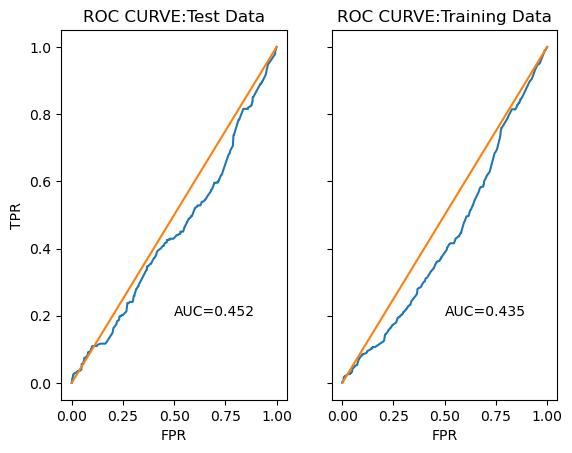

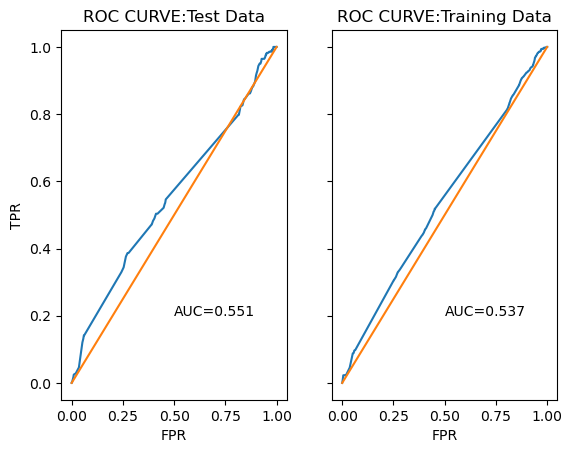

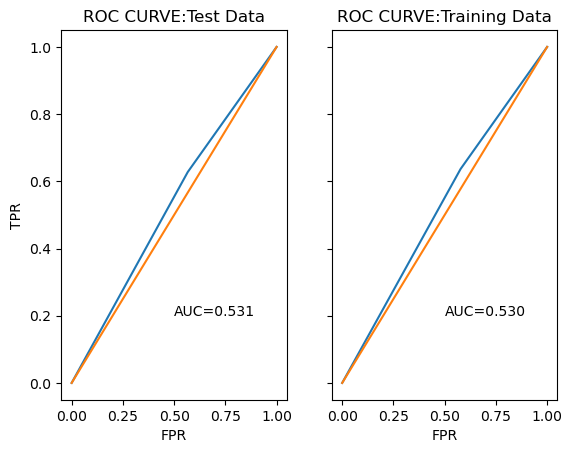

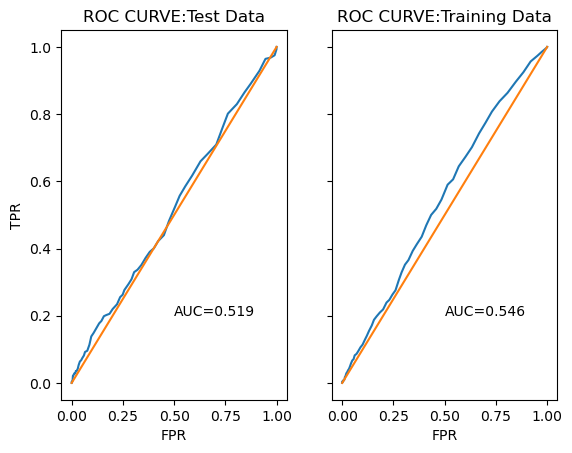

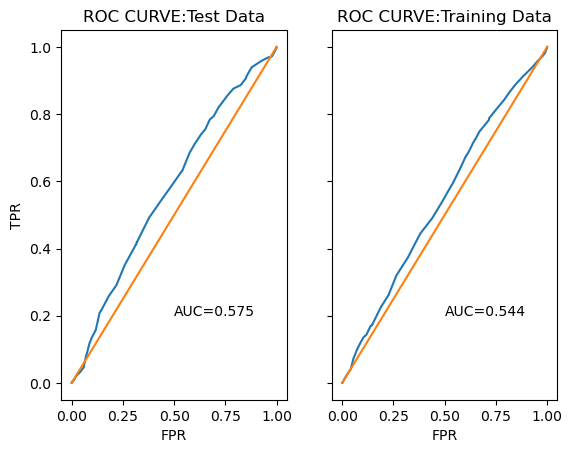

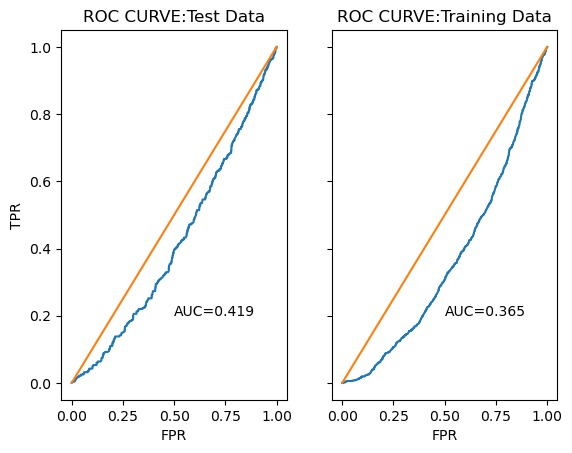

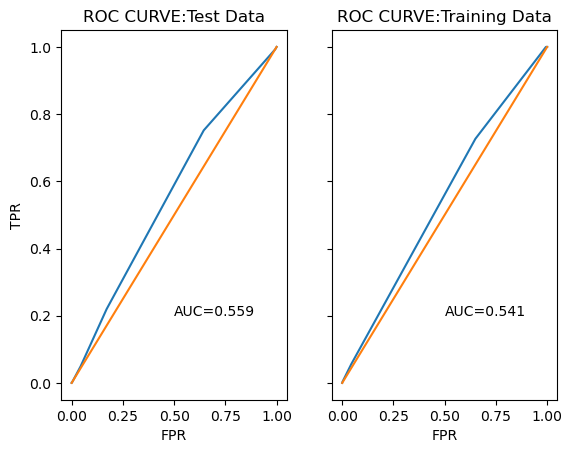

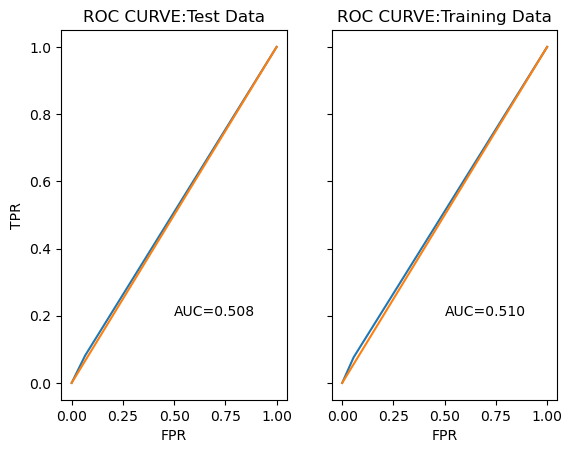

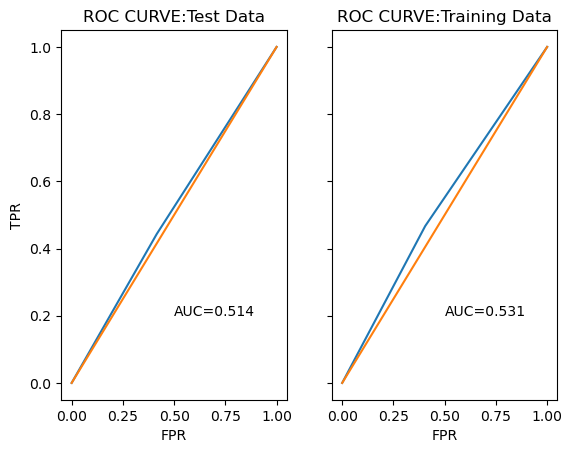

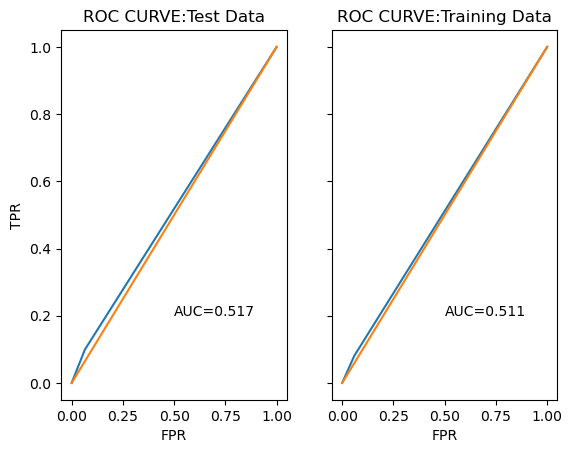

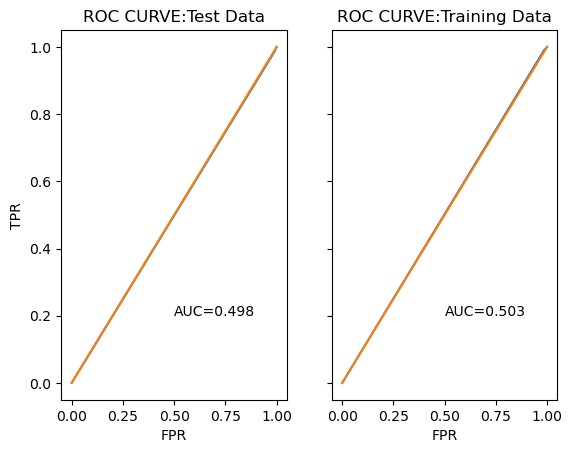

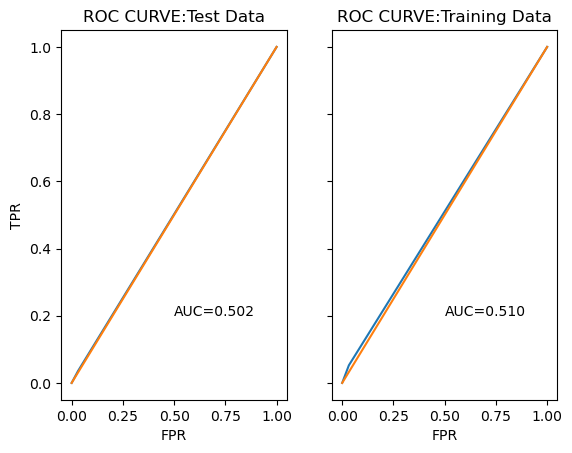

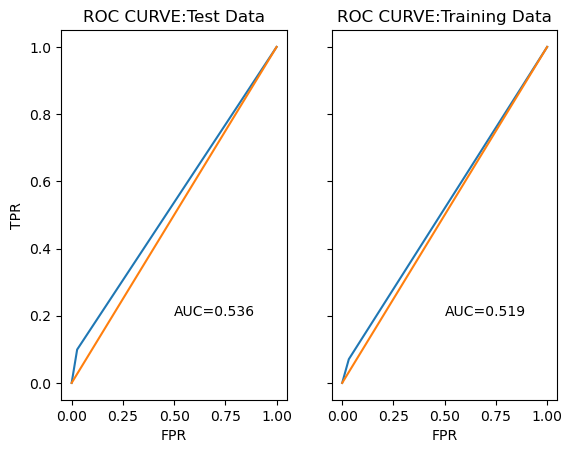

In [11]:
# I decided to do a bottom up approach, with care to avoid pairing highly correlated variables
varlist = list(final_data.columns)[:len(list(final_data.columns))-1]
for i in varlist:
    print(i)
    model_data(final_data[[i,'DebtBurdened']])
# The fourth variable TotalMonthlyIncomeAmount had the highest AUC value in the testing set. 
#It will be included in the final model and highly correlated variables CensusTractMedFamIncomeAmount','LocalAreaMedianIncomeAmount',
#'HUDMedianIncomeAmount', and 'NoteAmount' will be dropped from consideration 


CensusTractMinorityRatioPercent
Variables Included
['CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
LTVRatioPercent
Variables Included
['LTVRatioPercent', 'TotalMonthlyIncomeAmount']
BorrowerFirstTimeHomebuyer
Variables Included
['BorrowerFirstTimeHomebuyer', 'TotalMonthlyIncomeAmount']
Borrower1AgeAtApplicationYears
Variables Included
['Borrower1AgeAtApplicationYears', 'TotalMonthlyIncomeAmount']
NoteRatePercent
Variables Included
['NoteRatePercent', 'TotalMonthlyIncomeAmount']
Borrower1CreditScoreValue
Variables Included
['Borrower1CreditScoreValue', 'TotalMonthlyIncomeAmount']
EmploymentBorrowerSelfEmployed
Variables Included
['EmploymentBorrowerSelfEmployed', 'TotalMonthlyIncomeAmount']
IsFemale
Variables Included
['IsFemale', 'TotalMonthlyIncomeAmount']
IsHispanic
Variables Included
['IsHispanic', 'TotalMonthlyIncomeAmount']
IsNativeAmerican
Variables Included
['IsNativeAmerican', 'TotalMonthlyIncomeAmount']
IsAsian
Variables Included
['IsAsian', 'TotalMonthlyIncome

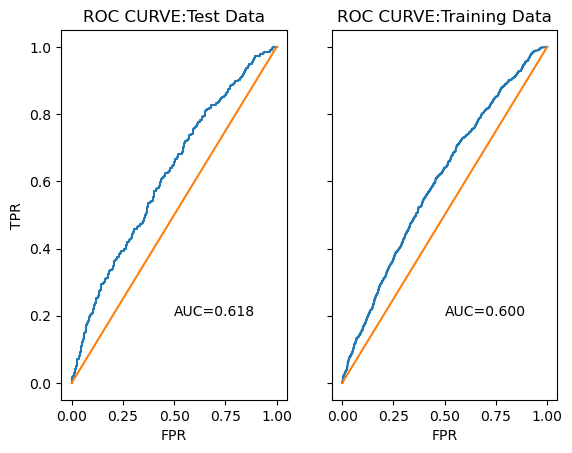

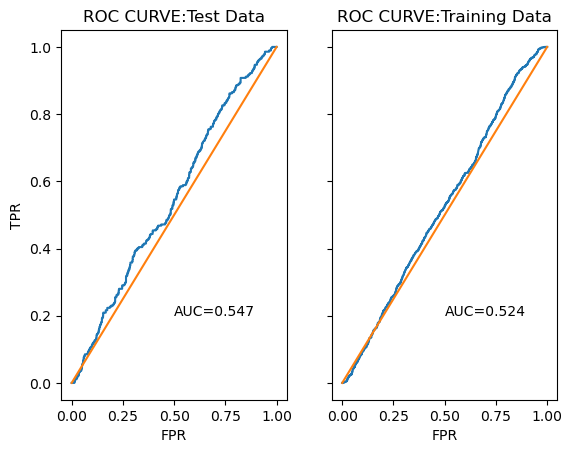

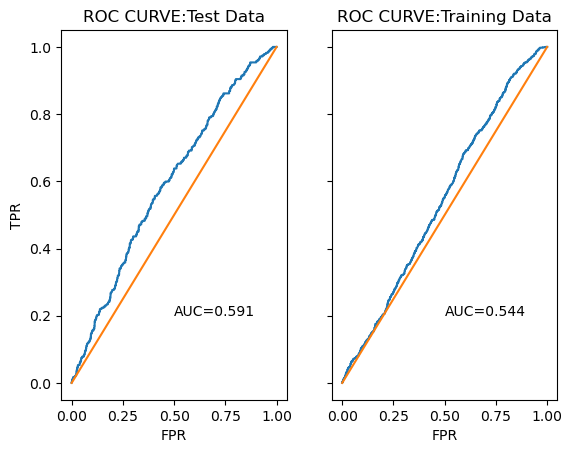

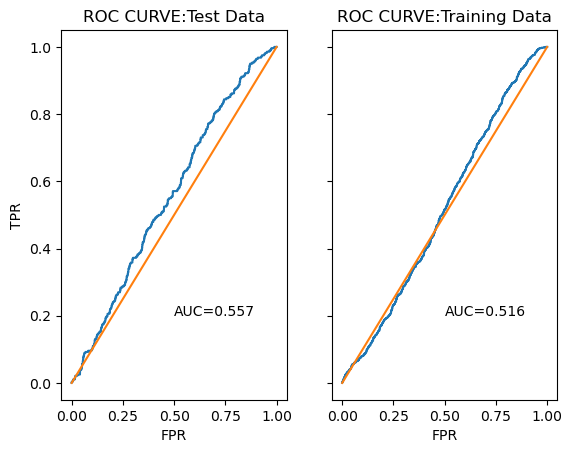

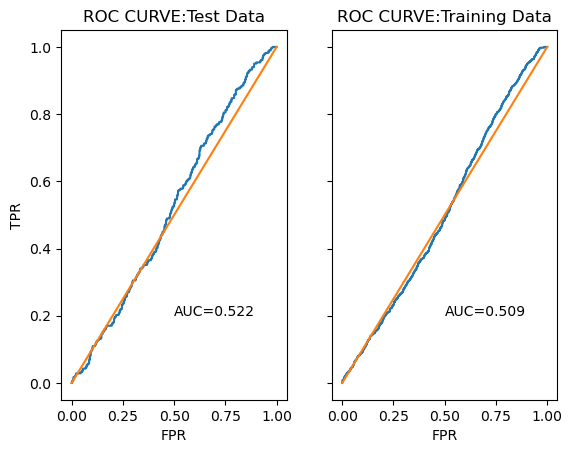

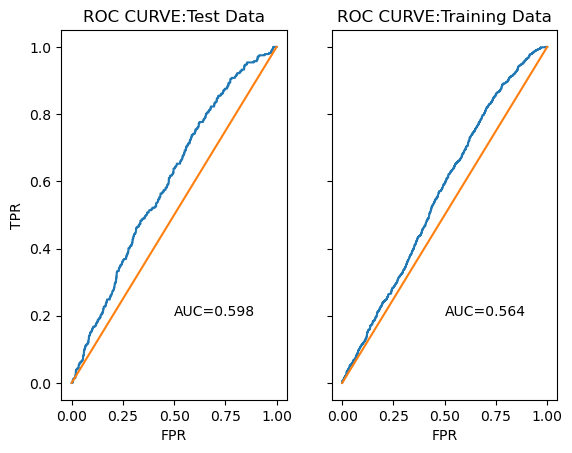

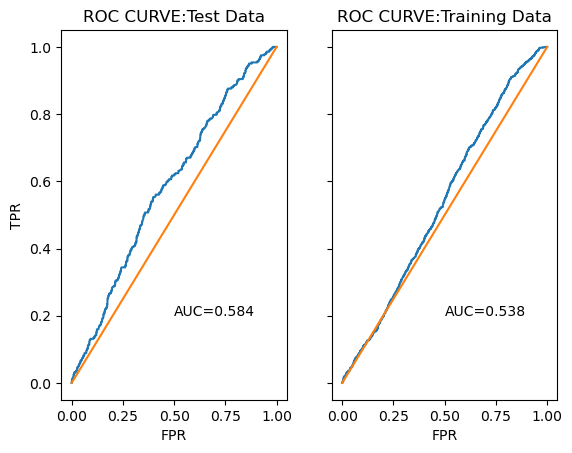

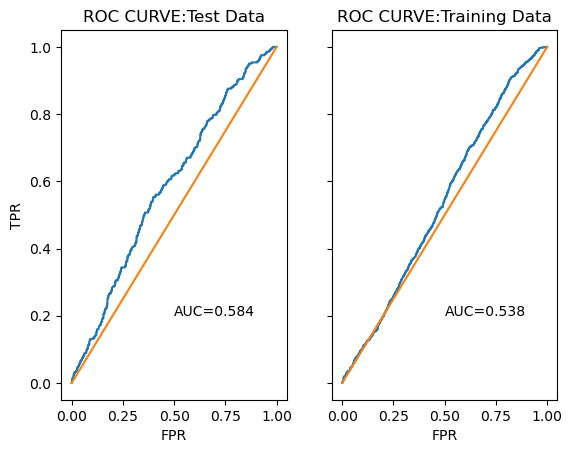

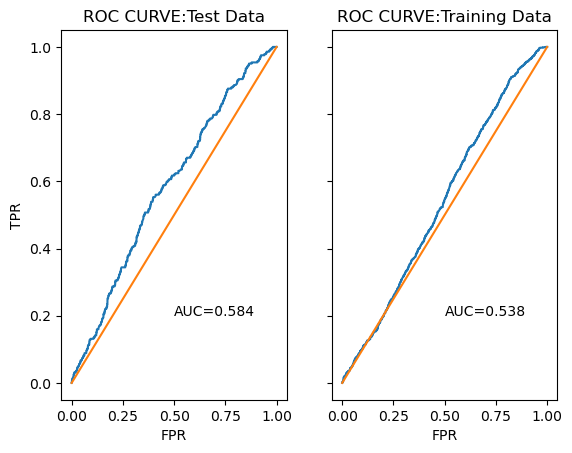

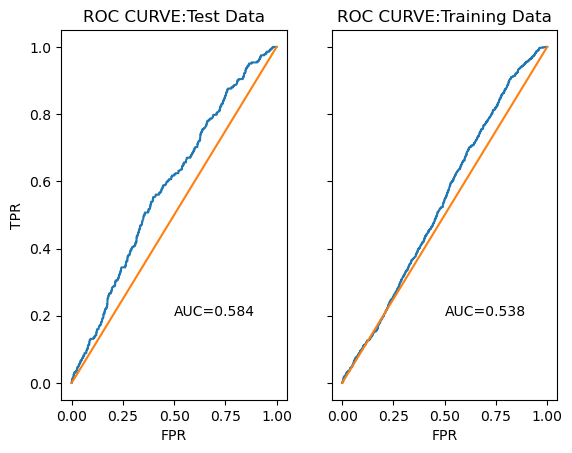

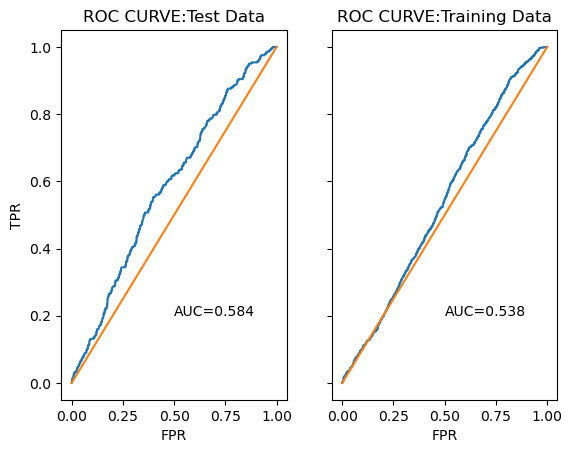

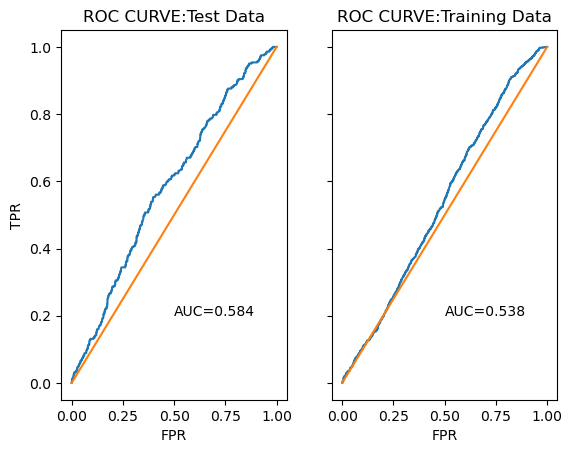

In [12]:
remain_vars2 = final_data[['CensusTractMinorityRatioPercent', 'LTVRatioPercent', 'BorrowerFirstTimeHomebuyer', 'Borrower1AgeAtApplicationYears', 'NoteRatePercent', 'Borrower1CreditScoreValue', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsHispanic', 'IsNativeAmerican', 'IsAsian', 'IsBlack','TotalMonthlyIncomeAmount']]
varlist2 = list(remain_vars2.columns)[:len(list(remain_vars2.columns))-1]
for i in varlist2:
    print(i)
    model_data(final_data[[i,'TotalMonthlyIncomeAmount','DebtBurdened']])
# The first variable CensusTractMinorityRatioPercent had the highest AUC value in the testing set. 
#It is somewhat correlated with 'IsHispanic', 'IsAsian', and 'IsBlack' so those will be dropped from further consideration 

LTVRatioPercent
Variables Included
['LTVRatioPercent', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
BorrowerFirstTimeHomebuyer
Variables Included
['BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
Borrower1AgeAtApplicationYears
Variables Included
['Borrower1AgeAtApplicationYears', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
NoteRatePercent
Variables Included
['NoteRatePercent', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
Borrower1CreditScoreValue
Variables Included
['Borrower1CreditScoreValue', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
EmploymentBorrowerSelfEmployed
Variables Included
['EmploymentBorrowerSelfEmployed', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsFemale
Variables Included
['IsFemale', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsNativeAmerican
Variables Included
['IsNativeAmerican', 'CensusTractMinorityRatioPerc

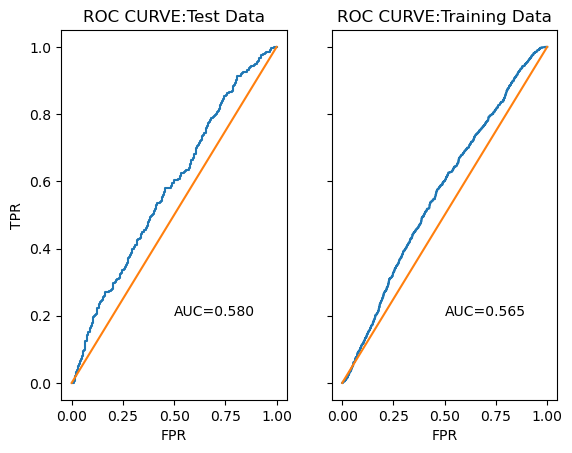

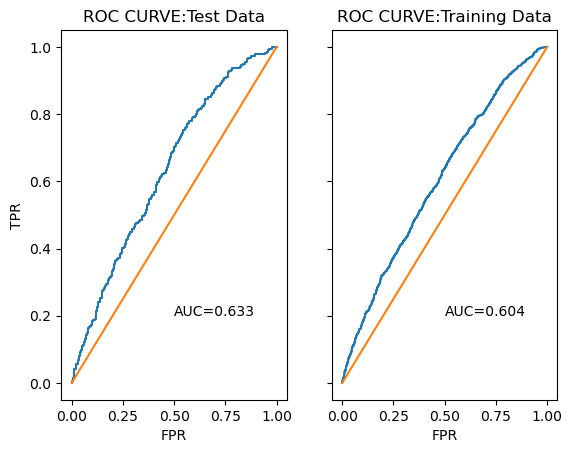

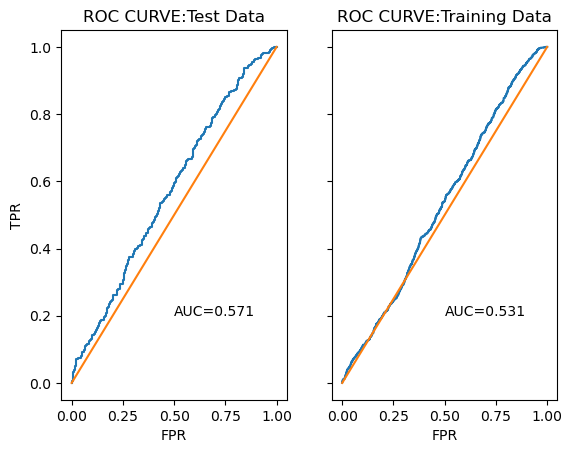

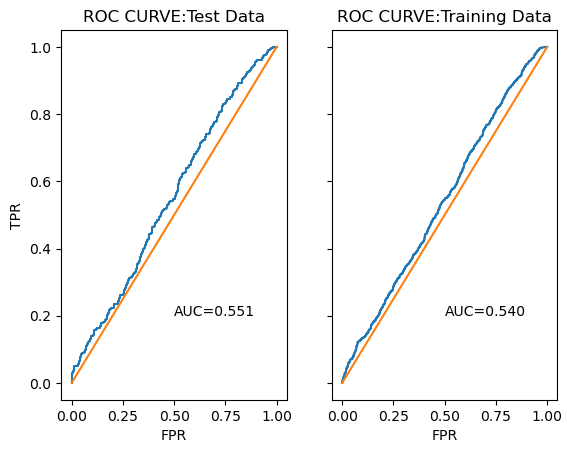

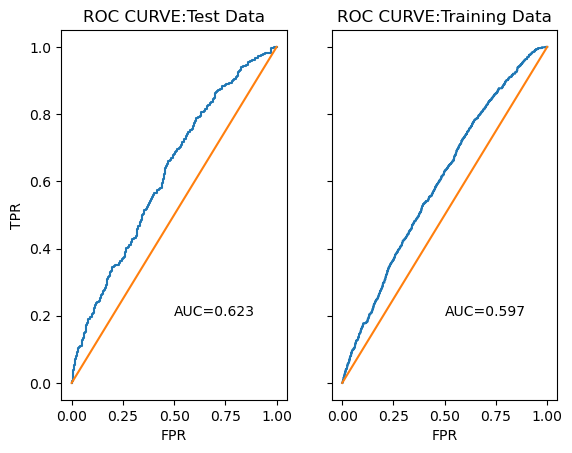

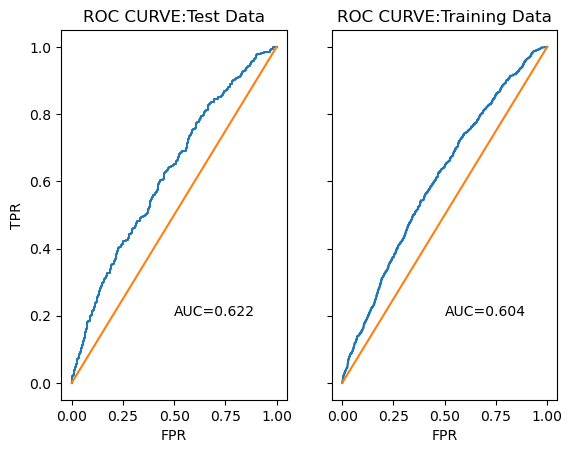

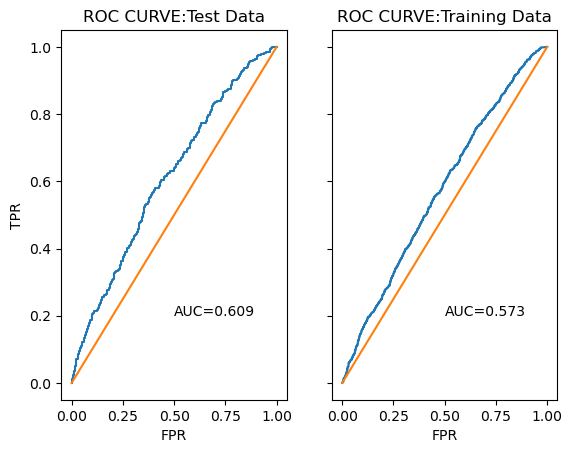

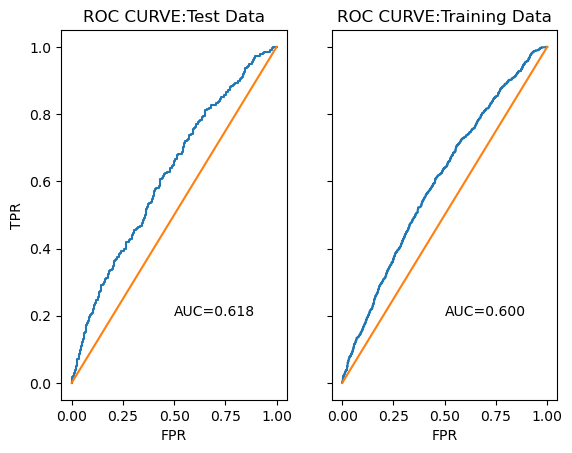

In [13]:
remain_vars3 = final_data[['LTVRatioPercent', 'BorrowerFirstTimeHomebuyer', 'Borrower1AgeAtApplicationYears', 'NoteRatePercent', 'Borrower1CreditScoreValue', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsNativeAmerican','CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount']]
varlist3 = list(remain_vars3.columns)[:len(list(remain_vars3.columns))-2]
for i in varlist3:
    print(i)
    model_data(final_data[[i,'CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount','DebtBurdened']])
#'BorrowerFirstTimeHomebuyer' had the highest AUC value when added to the model. 
#It has a strong negative correlation Borrower1AgeAtApplicationYears so that will be removed from consideration. 

LTVRatioPercent
Variables Included
['LTVRatioPercent', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
NoteRatePercent
Variables Included
['NoteRatePercent', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
Borrower1CreditScoreValue
Variables Included
['Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
EmploymentBorrowerSelfEmployed
Variables Included
['EmploymentBorrowerSelfEmployed', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsFemale
Variables Included
['IsFemale', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsNativeAmerican
Variables Included
['IsNativeAmerican', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']


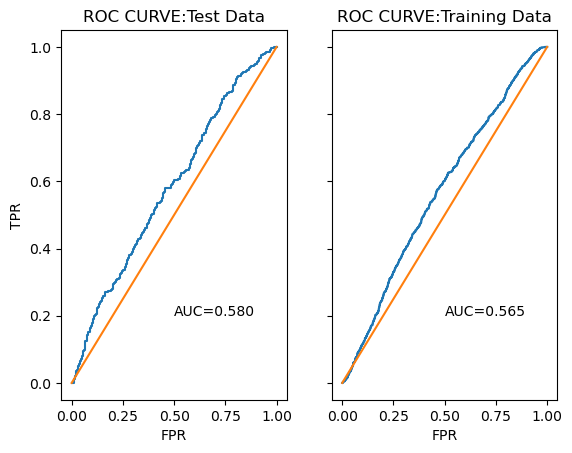

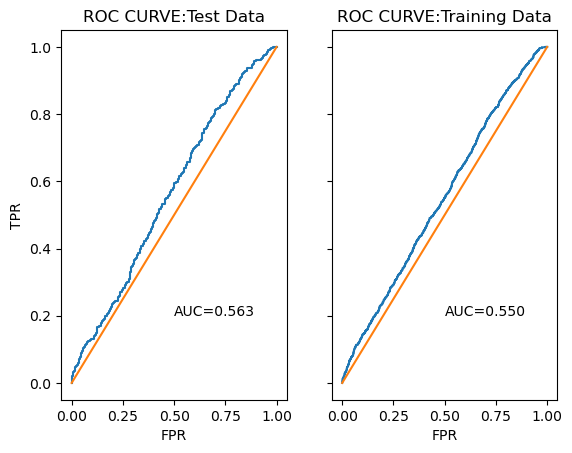

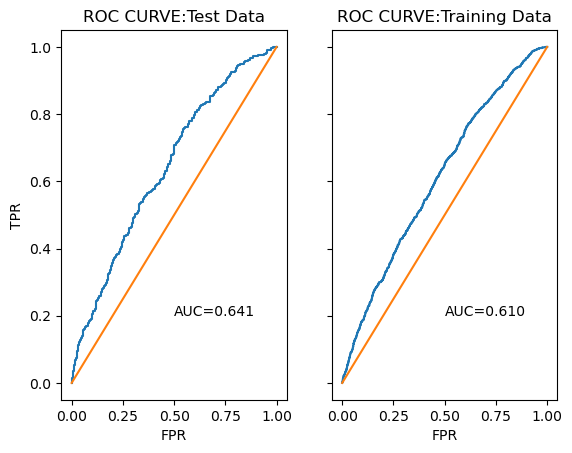

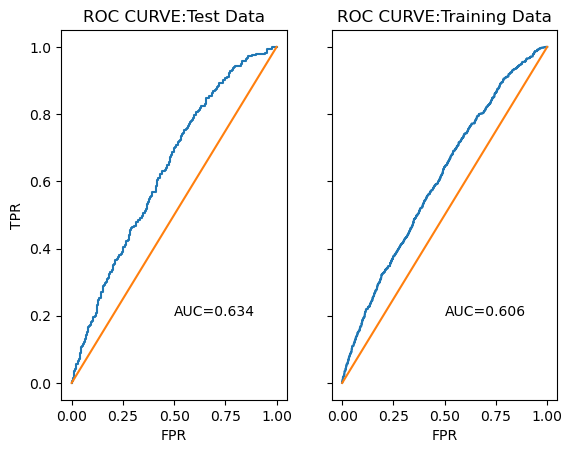

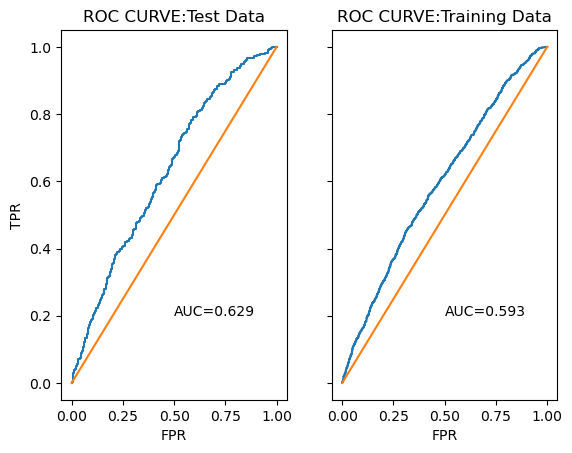

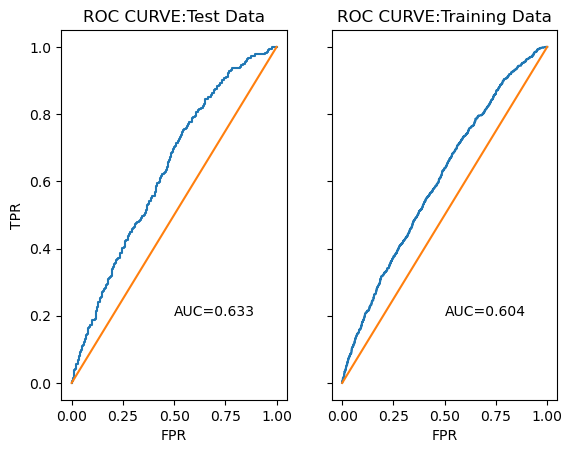

In [14]:
remain_vars4 = final_data[['LTVRatioPercent', 'NoteRatePercent', 'Borrower1CreditScoreValue', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsNativeAmerican']]
varlist4 = list(remain_vars4.columns)[:len(list(remain_vars4.columns))]
for i in varlist4:
    print(i)
    model_data(final_data[[i,'BorrowerFirstTimeHomebuyer','CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount','DebtBurdened']])
#'Borrower1CreditScoreValue' had the highest AUC value when added to the model. 
# This variable has no strong correlations with any of the remaining variables so none will be removed from consideration. 

LTVRatioPercent
Variables Included
['LTVRatioPercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
NoteRatePercent
Variables Included
['NoteRatePercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
EmploymentBorrowerSelfEmployed
Variables Included
['EmploymentBorrowerSelfEmployed', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsFemale
Variables Included
['IsFemale', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsNativeAmerican
Variables Included
['IsNativeAmerican', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']


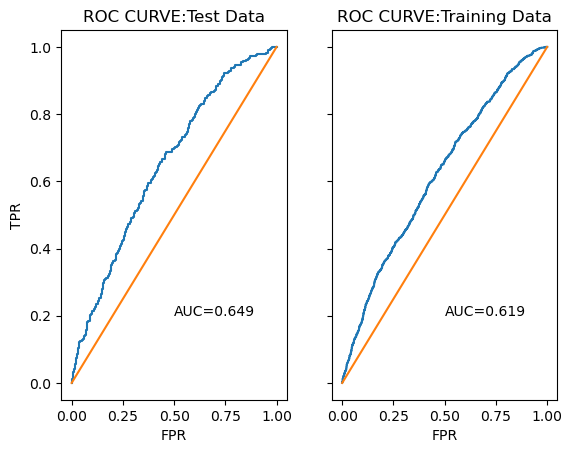

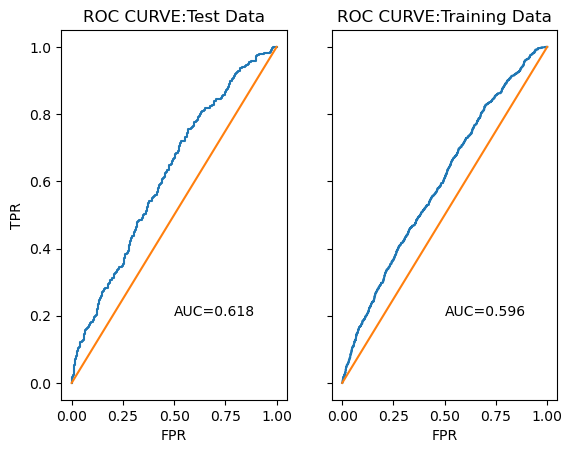

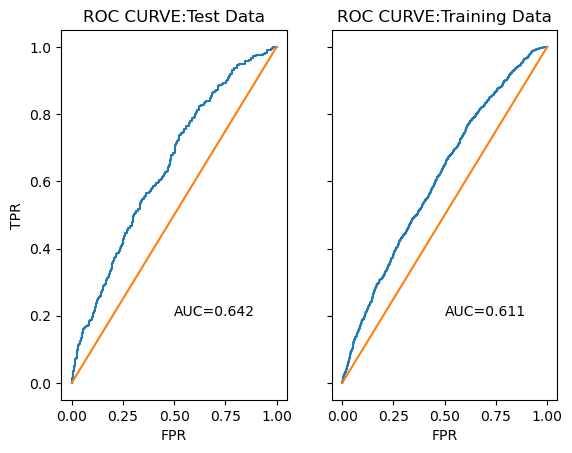

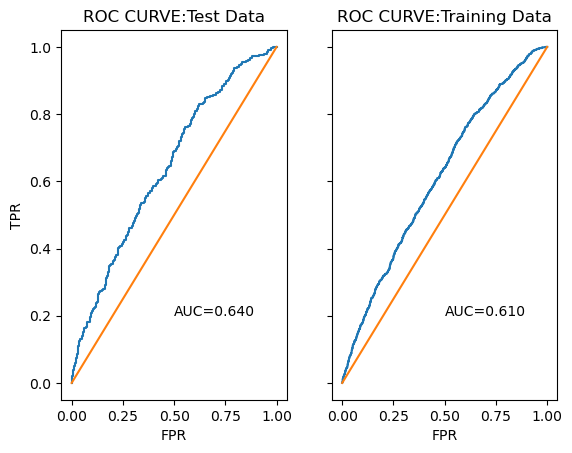

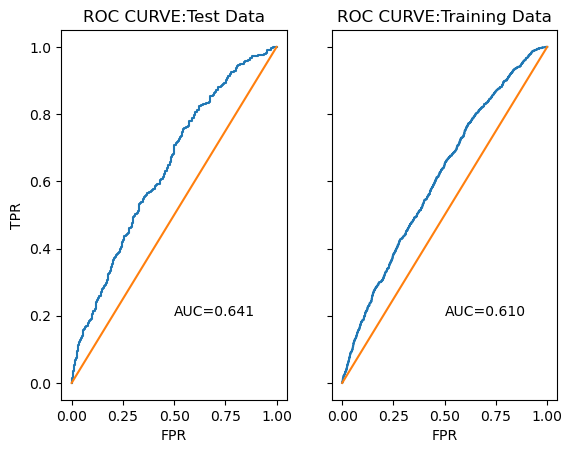

In [15]:
remain_vars5 = final_data[['LTVRatioPercent', 'NoteRatePercent', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsNativeAmerican']]
varlist5 = list(remain_vars5.columns)[:len(list(remain_vars5.columns))]
for i in varlist5:
    print(i)
    model_data(final_data[[i,'Borrower1CreditScoreValue','BorrowerFirstTimeHomebuyer','CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount','DebtBurdened']])
#The first value 'LTVRatioPercent' had the highest AUC when added to the model. 
# This variable has no strong correlations with any of the remaining variables so none will be removed from consideration.    

NoteRatePercent
Variables Included
['NoteRatePercent', 'LTVRatioPercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
EmploymentBorrowerSelfEmployed
Variables Included
['EmploymentBorrowerSelfEmployed', 'LTVRatioPercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsFemale
Variables Included
['IsFemale', 'LTVRatioPercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
IsNativeAmerican
Variables Included
['IsNativeAmerican', 'LTVRatioPercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']


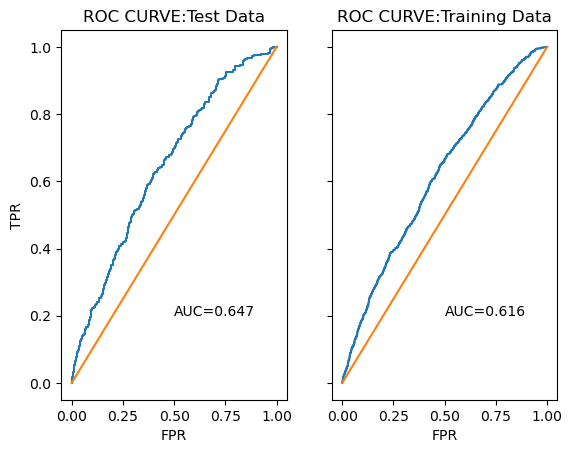

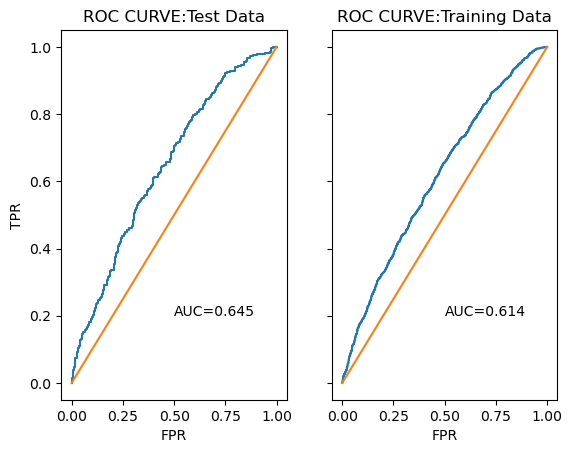

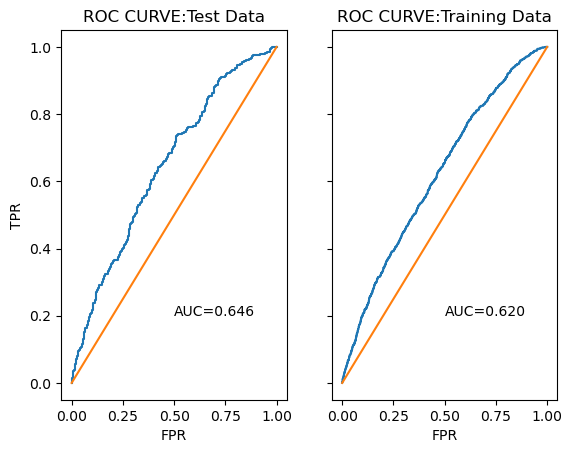

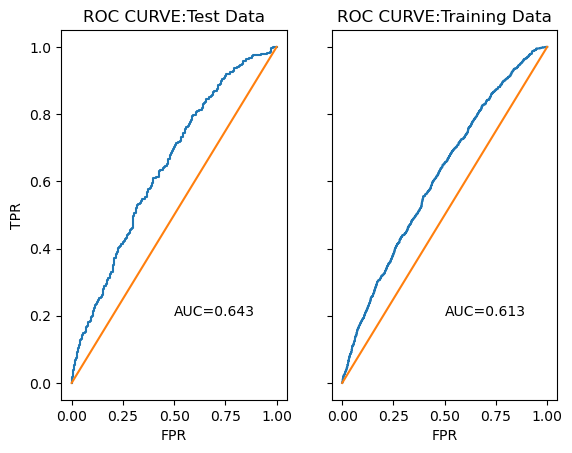

In [16]:
remain_vars6 = final_data[['NoteRatePercent', 'EmploymentBorrowerSelfEmployed', 'IsFemale', 'IsNativeAmerican']]
varlist6 = list(remain_vars6.columns)[:len(list(remain_vars6.columns))]
for i in varlist6:
    print(i)
    model_data(final_data[[i,'LTVRatioPercent','Borrower1CreditScoreValue','BorrowerFirstTimeHomebuyer','CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount','DebtBurdened']])
 #None of these variables increased the AUC value from the model with five independent variables, so the final model does not have an additional variable.   

Variables Included
['LTVRatioPercent', 'Borrower1CreditScoreValue', 'BorrowerFirstTimeHomebuyer', 'CensusTractMinorityRatioPercent', 'TotalMonthlyIncomeAmount']
Model Coefficients: [[ 3.93933271e-03 -2.95928326e-01 -5.91162794e-01  1.35878209e-02
  -8.81881725e-05]]
Logistic regression model accuracy:0.85


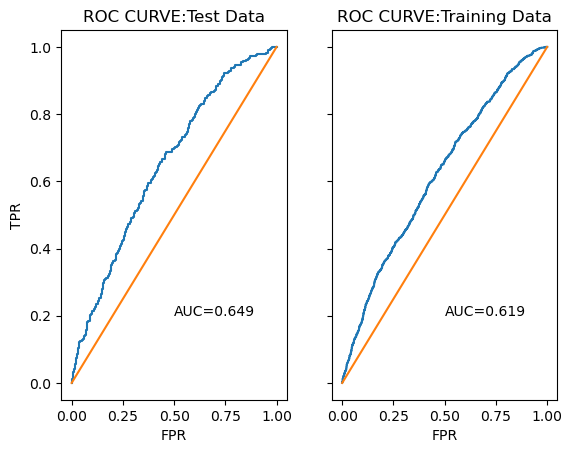

In [17]:
#The final model
fin_mod = model_data(final_data[['LTVRatioPercent','Borrower1CreditScoreValue','BorrowerFirstTimeHomebuyer','CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount','DebtBurdened']])
print("Model Coefficients:",fin_mod.coef_)
x_train, x_test, y_train, y_test = train_test_split(final_data[['LTVRatioPercent','Borrower1CreditScoreValue','BorrowerFirstTimeHomebuyer','CensusTractMinorityRatioPercent','TotalMonthlyIncomeAmount']],final_data['DebtBurdened'],random_state = 1)
y1_pred=fin_mod.predict(x_test)
print('Logistic regression model accuracy:{:.2f}'.format(fin_mod.score(x_test,y_test)))

Results and Analysis:
Variables in this dataset were able to contribute to a model that could predict is a borrower is debt burdened with an accuracy much  greater than random chance at 0.85. However it is still an imperfect classifier so there is certainly room for improvement. Building the model from the bottom up allowed for better avoidance of multicollinearity effects. These affects are the reason that the final model did not included every variable, despite the high AUC score of that model, the first developed for demonstration. Subsiquent models with only one or two variables had a lower AUC value, but adding more variables increased the predictive value of the model and carefully selecting them using ROC Curves peformance built a model with high accuracy. 

Discussion and Conclusion:
Data cleaning and organization was by far the biggest timesink in developing this model, and the dataset was well organized at the start with clear variable meanings. Developing a dataset that is useful for logistic regression takes effort, and in the future it would probably be benefifical to do more by normalizing or scale-reducing variables. It also shows how convenient python packages like pandas, sklearn, and pyplot can make developing machine learning models much more efficient. Without those, this project would have had much more room for potential human error as well. The intial expectation for this project was that borrower demographic information like race and age would be much more involved but that turned out to not be the case because of high correlations with other variables. It makes sense that a high percentage of minorities in the area is correlated with a borrower being a minority, but it was a shame that those could not both be included in a model. It is important to see how those could together effect potential debt burden, like if a minority borrower is more or less likely to be debt burdened if they live in a high minority population area. This dataset did not include a variable for what minorities make up the percentage but that could also be important. Future research in this will hopefully find relevant data for that component. 

In [ ]:
Github Repository:
    https://github.com/cthompson2121/IML_Final_Mortgage-DebtBurden